# XGBoost comparison
> Does XGBoost prefer mixture embeddings?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from util import load_task, mixture_embedding

INFO: Using numpy backend


In [3]:
N_DIM = 64

In [4]:
# Load embeddings

euc_embed = pd.read_csv(
    f"/home/phil/DATA/otu_embeddings/embeddings_euclidean_{N_DIM}.csv", 
    dtype={0: str}
)
euc_embed = euc_embed.set_index(euc_embed.columns[0])

In [5]:
# Preliminary experiment - we see embeddings do worse

def xgboost_experiment(X, y, **kwargs):
    model = xgb.XGBClassifier(**kwargs)
    return cross_val_score(model, X, y, cv=5)

dd = "/home/phil/mixture_embeddings/data/interim/mlrepo_clean/classification"

results = pd.DataFrame(
    columns=["task", "fold", "raw", "embed", "pca", "n_samples"], dtype=float
)

for subdir in os.listdir(dd):
    if not os.path.isdir(f"{dd}/{subdir}"):
        continue
    else:
        X, y = load_task(dd, subdir)
        acc = xgboost_experiment(X, y)

        # Embedding
        X_embed = mixture_embedding(X, euc_embed, geometry="euclidean")
        acc_embed = xgboost_experiment(X_embed, y)

        # PCA
        pca_dim = np.min([N_DIM, X.shape[0]])
        pca = PCA(n_components=pca_dim)
        X_pca = pca.fit_transform(X)
        acc_pca = xgboost_experiment(X_pca, y)

        # Push results
        for i in range(5):
            results.loc[len(results)] = [
                subdir, i, acc[i], acc_embed[i], acc_pca[i], X.shape[0]
            ]
results

,task,fold,raw,embed,pca,n_samples
0,ravel_black_hispanic,0,0.500000,0.650000,0.525000,199
1,ravel_black_hispanic,1,0.575000,0.450000,0.500000,199
2,ravel_black_hispanic,2,0.450000,0.550000,0.500000,199
3,ravel_black_hispanic,3,0.550000,0.625000,0.600000,199
4,ravel_black_hispanic,4,0.615385,0.461538,0.435897,199
...,...,...,...,...,...,...
85,ravel_black_white,0,0.575000,0.450000,0.675000,200
86,ravel_black_white,1,0.700000,0.425000,0.675000,200
87,ravel_black_white,2,0.650000,0.575000,0.600000,200
88,ravel_black_white,3,0.475000,0.550000,0.525000,200


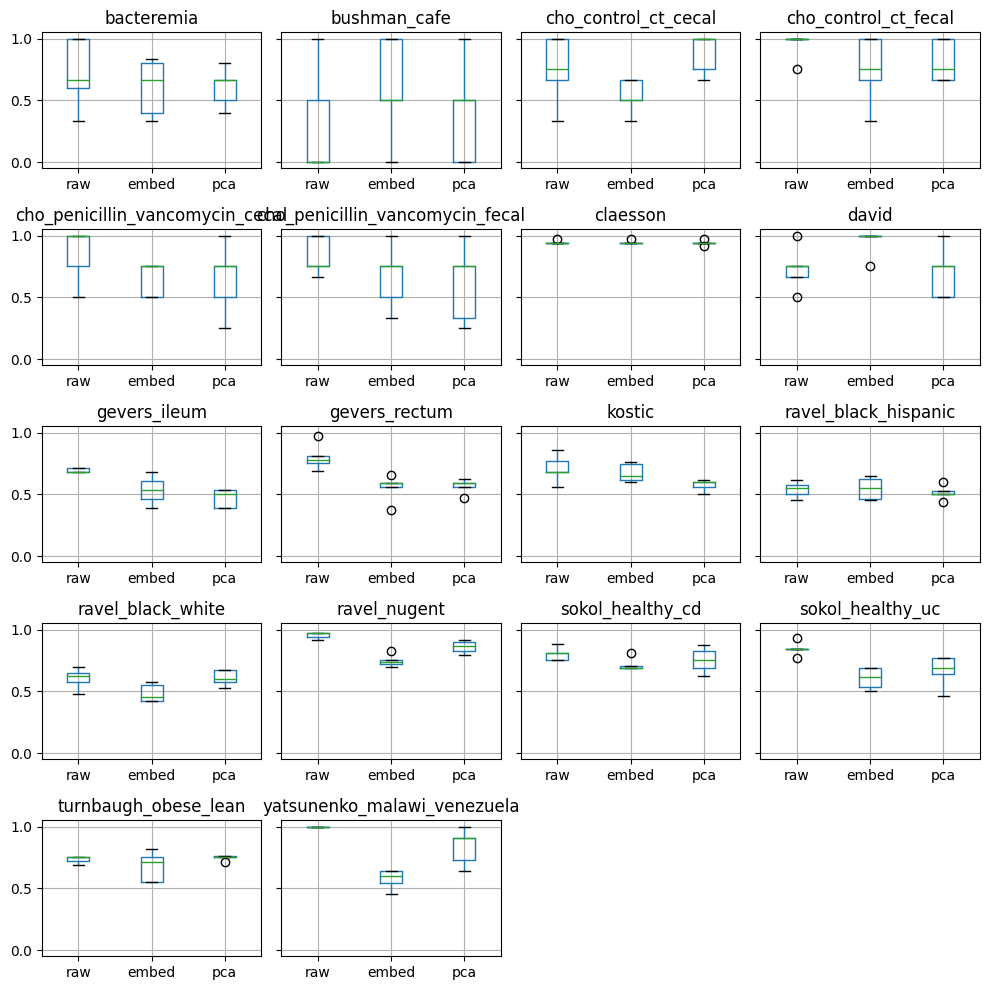

In [13]:
results.groupby("task").boxplot(column=["raw", "embed", "pca"], figsize=(10, 10))
plt.tight_layout()
plt.show()